# Photometry

> Author: *Valentin Christiaens* (Core Nb), Dominique Sluse  
> Package dependencies: astropy, matplotlib, numpy, photutils, scikit-image, scipy
>
> The data needed for this Nb should be downloaded separately along this link: [https://dox.uliege.be/index.php/s/rVCiGqm6oCQV4Pd](https://dox.uliege.be/index.php/s/rVCiGqm6oCQV4Pd)
> The data should be moved into the sub-directory `data` (i.e. child directory of the folder hosting this Nb) 
> 
> Last update: *2026/02/13*

---

## Table of contents

* [1. Aperture photometry of point sources](#1.-Aperture-photometry-of-point-sources)
    - [1.1. General procedure](#1.1.-General-procedure)
    - [1.2. Apertures](#1.2.-Apertures)
    - [1.3. Error estimation](#1.3.-Error-estimation)
    - [1.4. Aperture photometry with sky coordinates](#1.4.-Aperture-photometry-with-sky-coordinates)
* [2. Background subtraction](#2.-Background-subtraction)
    - [2.1. Constant value](#2.1.-Constant-value)
    - [2.2. Annular estimate](#2.2.-Annular-estimation)
    - [2.3. Gradient estimate](#2.3.-Gradient-estimate)
* [3. Source identification](#3.-Source-identification)
    - [3.1. Centroid measurement](#3.1.-Centroid-measurement)
    - [3.2. Image alignment](#3.2.-Image-alignment)
    - [3.3. Automatic source finding](#3.3.-Automatic-source-finding)

---

In this lecture, we will see how to tackle the common task of measuring the photometry (i.e. quantify the brightness) of point sources in astronomical images.

Before the advent of gravitational wave astronomy, *all* we knew about our Universe came from measuring the light of celestial objects. Chronologically: measurements were first made by eye (through an eyepiece after the invention of the telescope), then through photographic plates placed in the focal plane of the telescope, and more recently through electronic detectors (charge-coupled devices; CCD). 

Different instruments can be placed in the focal plane of a telescope to count photons, i.e. to perform **photometry**. Imagers (i.e. camera/detectors) provide the image of a field in which a number of sources may be located, and with source contributing the photon counts of different **pixels** in the image. 
Spectrographs are instruments dispersing the light coming from a given field-of-view before it hits the detector, and can come with various designs.
Some spectrograph designs enable the simultaneous acquisition of multi-wavelength images (e.g. integral field spectrographs), where the task of measuring photons from given sources is then referred to as **spectro-photometry**.

Note that high-spectral resolution spectrographs (e.g. Echelle spectrographs) typically do not provide spatial information - all the incoming light is dispersed. The outcome then takes the form of a 1D spectrum for the observed object/field.

**Goals of this lecture:** 

1. Be able to measure the photometry of point sources.
2. Be able to estimate and subtract the background contribution.
3. Know how to identify sources and measure their centroid location.
4. Know how to register observed images before stacking them.

In [1]:
# Let's import modules we will use a lot in this tutorial:
from matplotlib import pyplot as plt
import numpy as np

## 1. Aperture photometry of point sources

The most direct way to quantify the brightness of sources in astronomical images is to perform **aperture photometry**, that is to count and sum the number of photon hits on pixels within a given aperture encompassing the source.

The size of the aperture should be well chosen to either capture most of the flux of the star, or a well-characterized fraction of the whole incoming flux.

The package offering the most options in that purpose is the Astropy-affiliated package `photutils`.

The `aperture_photometry()` function and the `ApertureStats` class are the main tools to perform aperture photometry on an astronomical image for a given set of apertures.

Photutils provides several apertures defined in pixel or sky coordinates. The aperture classes that are defined in pixel coordinates are:

- `CircularAperture`
- `CircularAnnulus`
- `EllipticalAperture`
- `EllipticalAnnulus`
- `RectangularAperture`
- `RectangularAnnulus`

Each of these classes has a corresponding variant defined in sky coordinates:

- `SkyCircularAperture`
- `SkyCircularAnnulus`
- `SkyEllipticalAperture`
- `SkyEllipticalAnnulus`
- `SkyRectangularAperture`
- `SkyRectangularAnnulus`

To perform aperture photometry with sky-based apertures, one needs to specify a WCS transformation.

### 1.1. General procedure

The first step in performing aperture photometry with `photutils` is to create an **aperture object**. An aperture object is defined by a position (or a list of positions) and parameters that define its size and possibly, orientation (e.g., for an elliptical aperture).

**Example**: Let's create a circular aperture in pixel coordinates using the `CircularAperture` class:

In [3]:
from photutils.aperture import CircularAperture

aperture = CircularAperture((30, 30), r=3.0)

After the aperture object is created, we can perform the photometry using the `aperture_photometry()` function, providing it both the data and the aperture(s).

**Example:** Let's consider an array of all ones and integrate the flux over the apertures defined above. 

In [4]:
from photutils.aperture import aperture_photometry

data = np.ones((100, 100))
phot_table = aperture_photometry(data, aperture)

In [5]:
#phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter    aperture_sum   
--- ------- ------- ------------------
  1    30.0    30.0 28.274333882308134


This function returns the results of the photometry in an Astropy **QTable**. In this example, the table has four columns, named 'id', 'xcenter', 'ycenter', and 'aperture_sum'.

Since all the data values are 1.0, the aperture sums are equal to the area of a circle with a radius of 3:

In [7]:
print(np.pi * 3.0** 2)

28.274333882308138


### 1.2. Apertures

Photutils provides several apertures defined in pixel or sky coordinates. The aperture classes that are defined in pixel coordinates are:

- `CircularAperture`
- `CircularAnnulus`
- `EllipticalAperture`
- `EllipticalAnnulus`
- `RectangularAperture`
- `RectangularAnnulus`

Let's assume we want to consider several apertures at once:

In [11]:
from photutils.aperture import CircularAperture

positions = [(30.0, 30.0), (40.0, 40.0), (40.0, 99.0)]
apertures = CircularAperture(positions, r=3.0)

The positions should be either a single tuple of (x, y) - as seen in the previous section - or a list of (x, y) tuples, or an array with shape Nx2, where N is the number of positions.

The above example defines two circular apertures with a radius of 3 pixels, and located at pixel coordinates (30, 30) and (40, 40).

In [12]:
phot_table = aperture_photometry(data, apertures)
print(phot_table)

 id xcenter ycenter    aperture_sum   
--- ------- ------- ------------------
  1    30.0    30.0 28.274333882308134
  2    40.0    40.0 28.274333882308134
  3    40.0    99.0  17.12321959990618


One can also consider a list of apertures, for example with **multiple aperture sizes**:

In [14]:
radii = [3.0, 4.0, 5.0]
apertures = [CircularAperture(positions, r=r) for r in radii]
apertures

[<CircularAperture([[30., 30.],
                  [40., 40.],
                  [40., 99.]], r=3.0)>,
 <CircularAperture([[30., 30.],
                  [40., 40.],
                  [40., 99.]], r=4.0)>,
 <CircularAperture([[30., 30.],
                  [40., 40.],
                  [40., 99.]], r=5.0)>]

In [15]:
phot_table = aperture_photometry(data, apertures)
print(phot_table)

 id xcenter ycenter   aperture_sum_0     aperture_sum_1     aperture_sum_2 
--- ------- ------- ------------------ ------------------ -----------------
  1    30.0    30.0 28.274333882308134  50.26548245743669 78.53981633974485
  2    40.0    40.0 28.274333882308134  50.26548245743669 78.53981633974485
  3    40.0    99.0  17.12321959990618 29.122300010705835 44.26156229167796


<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 1.1:** Measure the aperture photometry of star HD 135344 B ('data/SPHERE_PSF_HD135.fits') in detector units for different, increasing, aperture sizes (from 1 to 80 pixels by steps of 1). Make a plot of the measured flux as a function of aperture size, and estimate the aperture radius which encompasses half of the total energy.

Tip: here it is fine to consider the coordinates of the peak intensity pixel for the center of the aperture.
</div>

In [16]:
from astropy.io import fits
image = fits.getdata('data/SPHERE_PSF_HD135.fits')

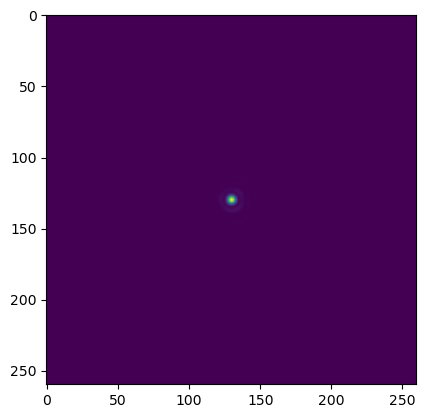

In [17]:
plt.imshow(image)

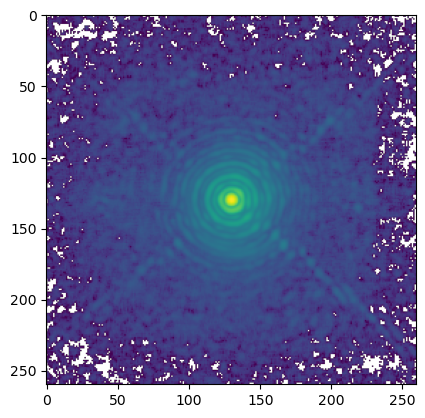

In [18]:
from matplotlib.colors import LogNorm

plt.imshow(image, norm=LogNorm(vmin=1, vmax=np.max(image))) 

In [20]:
max_yx = np.argmax(image)
print(max_yx)

33930


In [21]:
cy, cx = np.unravel_index(max_yx, image.shape)
cy, cx

(np.int64(130), np.int64(130))

In [22]:
radii = range(1, 81)
position = (cx, cy)
apertures = [CircularAperture(position, r=r) for r in radii]

In [23]:
phot_table = aperture_photometry(image, apertures)
phot_table

<QTable length=1>
  id  xcenter ycenter ...  aperture_sum_77   aperture_sum_78   aperture_sum_79 
int64 float64 float64 ...      float64           float64           float64     
----- ------- ------- ... ----------------- ----------------- -----------------
    1   130.0   130.0 ... 6777627.445087061 6784608.709403216 6791952.081355901

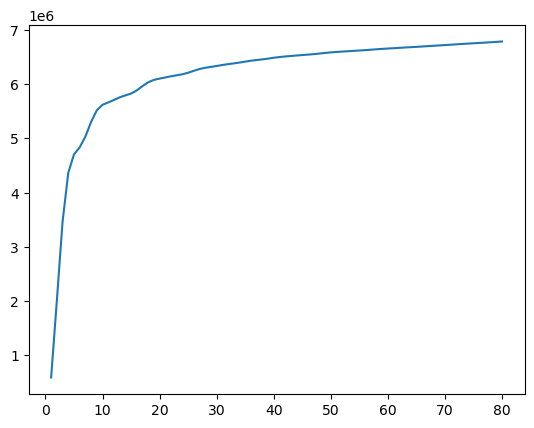

In [24]:
fluxes = [float(phot_table['aperture_sum_{}'.format(r-1)][0]) for r in radii]
plt.plot(radii, fluxes)

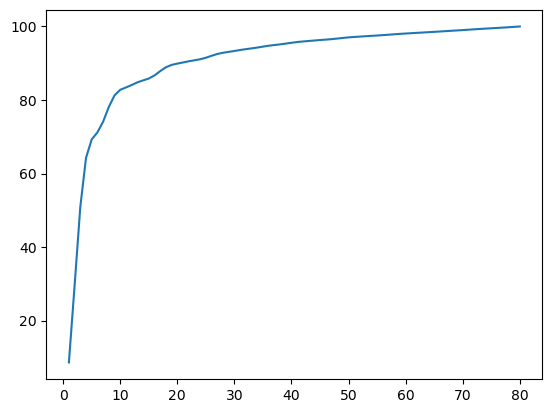

In [25]:
enc_energy = [fluxes[i]/fluxes[-1] for i in range(len(fluxes))]
enc_energy = 100*np.array(enc_energy)
plt.plot(radii, enc_energy)

Find the closest aperture to 50%:

In [26]:
radii[np.argmin(np.abs(enc_energy-50))] # this radius (in  pixels) contains 50% of the total flux 

3

In [27]:
enc_energy

array([  8.61492782,  29.53064786,  50.94248753,  64.2696453 ,
        69.29562156,  71.20446694,  74.1270253 ,  78.12838037,
        81.28379936,  82.78036311,  83.41896513,  84.08088698,
        84.80389806,  85.33545182,  85.84170334,  86.69311776,
        87.85948559,  88.90817505,  89.54922801,  89.90397678,
        90.21372776,  90.53237696,  90.80567204,  91.08624881,
        91.49566793,  92.02579067,  92.51599567,  92.85417253,
        93.09374146,  93.33787751,  93.60091312,  93.83504196,
        94.03855899,  94.26195752,  94.5194236 ,  94.76204152,
        94.95545491,  95.13317565,  95.3407988 ,  95.5678793 ,
        95.76717113,  95.92062547,  96.05222112,  96.18423341,
        96.3101703 ,  96.42592124,  96.55328732,  96.71142582,
        96.88469542,  97.03717379,  97.15419319,  97.25230559,
        97.35074819,  97.44900995,  97.5451434 ,  97.64565912,
        97.75918365,  97.87894029,  97.98885211,  98.08464877,
        98.17589377,  98.26879908,  98.36125588,  98.45

In [28]:
# alternative way to find that radius 
id_50 = np.searchsorted(enc_energy, 50, side='left')
id_50, radii[id_50]

(np.int64(2), 3)

In [29]:
enc_energy[2:4]

array([50.94248753, 64.2696453 ])

**Alternative** (shortcut) method using `CurveOfGrowth` to plot the profile:

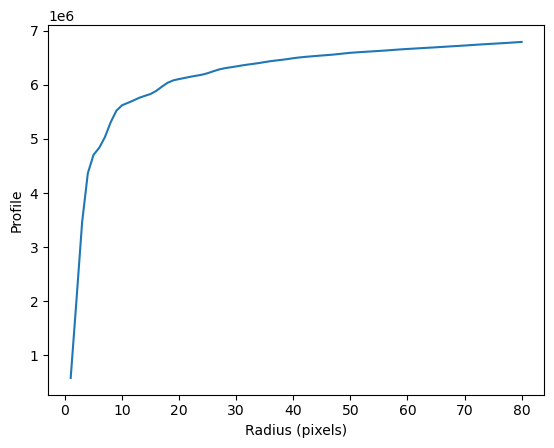

In [30]:
from photutils.profiles import CurveOfGrowth
radii = np.arange(1, 81)
cog = CurveOfGrowth(image, position, radii)

cog.plot()

### 1.3. Uncertainty estimation

If and only if the `error` keyword is input to `aperture_photometry()`, the returned table will include a 'aperture_sum_err' column in addition to 'aperture_sum'. 'aperture_sum_err' provides the propagated uncertainty associated with 'aperture_sum'. The error is has to be an array representing the $1 \sigma$ Gaussian uncertainty on the prixels in the images. 

**Example:**

In [31]:
positions = [(30.0, 30.0), (40.0, 40.0)]
aperture = CircularAperture(positions, r=3.0)
data = np.ones((100, 100))
error = 0.1 * data  # Error map - Arbitrary value to illustrate how to use it in aperture photometry

phot_table = aperture_photometry(data, aperture, error=error)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output: force 8 significant digits
print(phot_table)

 id xcenter ycenter aperture_sum aperture_sum_err
--- ------- ------- ------------ ----------------
  1      30      30    28.274334       0.53173616
  2      40      40    28.274334       0.53173616


### 1.4. Aperture photometry with sky coordinates

Analogous to detector-based apertures, one can also define apertures in sky coordinates:

- `SkyCircularAperture`
- `SkyCircularAnnulus`
- `SkyEllipticalAperture`
- `SkyEllipticalAnnulus`
- `SkyRectangularAperture`
- `SkyRectangularAnnulus`


Creating an aperture object in sky coordinates is straightforward. One first uses the `SkyCoord` class to define sky coordinates and then the `SkyCircularAperture` class to define the aperture object:

In [32]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture

positions_sky = SkyCoord(l=[1.2, 2.3] * u.deg, b=[0.1, 0.2] * u.deg, frame='galactic')
aperture_sky = SkyCircularAperture(positions_sky, r=4.0 * u.arcsec)

Then to perform aperture photometry with sky-based apertures, one needs to specify a WCS transformation.

**Example:** Let's measure the photometry of sources in a Spitzer 4.5 micron image of a region of the Galactic plane. The image and the catalog are part of the `photutils.datasets` modelule. 

In [33]:
import astropy.units as u
from astropy.wcs import WCS
from photutils.datasets import load_spitzer_catalog, load_spitzer_image

spitzer_hdu = load_spitzer_image()
spitzer_image = spitzer_hdu.data
data = u.Quantity(spitzer_image, unit=spitzer_hdu.header['BUNIT'])  
wcs = WCS(spitzer_hdu.header)
catalog = load_spitzer_catalog()  

In [34]:
catalog[0:5]

<Table length=5>
    l        b        f4_5     df4_5  ... color45_58 color45_80 color58_80
   deg      deg       mJy       mJy   ...                                 
 float64  float64   float64   float64 ...  float64    float64    float64  
--------- -------- ---------- ------- ... ---------- ---------- ----------
18.384317 0.240381 186.399994   8.521 ...      0.299       0.33      0.031
 18.38085    0.205  50.439999   2.436 ...      0.111      0.118      0.007
18.383131 0.264819  59.169998   3.492 ...      0.246      0.235     -0.011
18.380336 0.264739  53.349998   2.641 ...      0.297      0.881      0.584
18.343074 0.298394  53.959999   2.073 ...      0.238      0.272      0.034

In [35]:
spitzer_hdu.header['BUNIT']

'MJy/sr'

Let's visualize the Spitzer image:

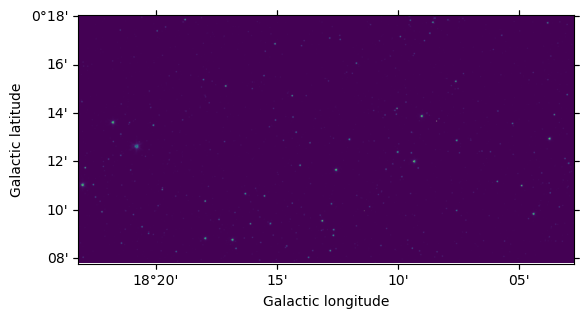

In [36]:
ax = plt.subplot(projection=wcs)   # This initialises your axes transforming it to WCS 
ax.imshow(spitzer_image, origin='lower')
#ax.grid(color='white', ls='solid')
ax.set_xlabel('Galactic longitude')
ax.set_ylabel('Galactic latitude')

The catalog contains (among other things) the Galactic coordinates of the sources in the image as well as the PSF-fitted fluxes from the official Spitzer data reduction. We define the apertures positions based on the existing catalog positions:

In [37]:
from astropy.coordinates import SkyCoord

positions = SkyCoord(catalog['l'], catalog['b'], frame='galactic')  
aperture = SkyCircularAperture(positions, r=4.8 * u.arcsec) 

Now perform the photometry in these apertures on the data. The wcs object contains the WCS transformation of the image obtained from the FITS header. It includes the coordinate frame of the image and the projection from sky to pixel coordinates. The aperture_photometry function uses the WCS information to automatically convert the apertures defined in sky coordinates into pixel coordinates:

In [38]:
phot_table = aperture_photometry(data, aperture, wcs=wcs)  

In [39]:
phot_table[0:5]

<QTable length=5>
  id       xcenter       ...     sky_center        aperture_sum   
                         ...      deg,deg            MJy / sr     
int64      float64       ...      SkyCoord           float64      
----- ------------------ ... ------------------ ------------------
    1  7.548988470491622 ... 18.384317,0.240381  5915.750141803915
    2 17.949988574503323 ...     18.38085,0.205 1631.4685786996042
    3 11.106988506073321 ... 18.383131,0.264819 1854.4486788993129
    4  19.49198858992031 ... 18.380336,0.264739  1521.091804285306
    5 131.27798970777553 ... 18.343074,0.298394 1690.2247871542947

In [40]:
# To compare the fluxes from the catalog with the aperture photometry, we need to convert the aperture sums to the same units as the catalog fluxes. 
# # The catalog fluxes are in mJy, and the aperture sums are in units of Mjy / sr. 
# We can use the pixel scale of the image to convert the aperture sums to fluxes in mJy.

import astropy.units as u
factor = (1.2 * u.arcsec) ** 2 / u.pixel
fluxes_catalog = catalog['f4_5']  
converted_aperture_sum = (phot_table['aperture_sum'] *
                          factor).to(u.mJy / u.pixel)  

Finally, we can plot the comparison of the photometry:

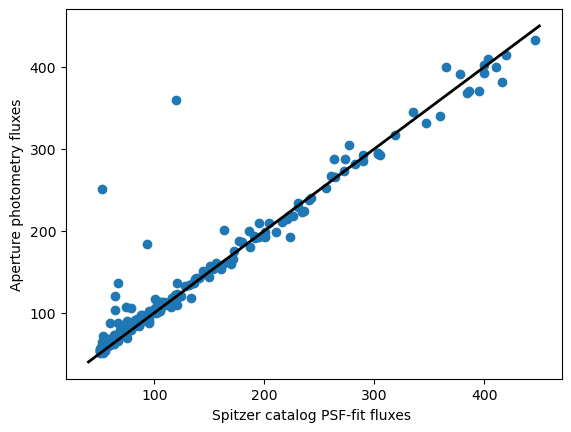

In [41]:
import matplotlib.pyplot as plt
plt.scatter(fluxes_catalog, converted_aperture_sum.value)
plt.xlabel('Spitzer catalog PSF-fit fluxes ')
plt.ylabel('Aperture photometry fluxes')
plt.plot([40, 100, 450], [40, 100, 450], color='black', lw=2)

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 2.1:** Read in the file `data/HelixNebula.fits` and:

1. Define a SkyCoord object containing the sky coordinates of the Helix nebula.
2. Measure the integrated flux at these sky coordinates in the image. Consider an aperture of 15 arcmin radius.

</div>

In [80]:
c_helix = SkyCoord.from_name("Helix nebula")  # use convenience function from_name to get coordinates of the Helix nebula
c_helix

<SkyCoord (ICRS): (ra, dec) in deg
    (337.41060585, -20.83715201)>

In [81]:
# Read the image and header of the Helix nebula
img_helix, head_helix = fits.getdata('data/HelixNebula.fits', header=True)

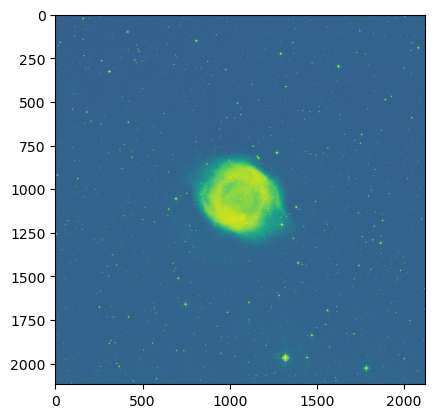

In [82]:
# display the image 
plt.imshow(img_helix)

In [83]:
# Get the wcs of the Helix nebula image
wcs_hel =  WCS(head_helix)

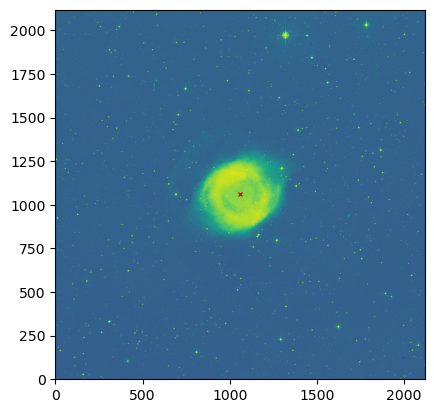

In [85]:
cxpix, cypix = wcs_hel.world_to_pixel(c_helix) # checking that the coordinates we got from the catalog match the image
plt.imshow(img_helix, origin='lower') # display image 
plt.plot(cxpix, cypix, marker='x', color='red', markersize=3) # overlay coordinates in red 

In [86]:
# Make sky aperture photometry 
aperture = SkyCircularAperture(c_helix, r=15 * u.arcmin)
phot_table =  aperture_photometry(img_helix, aperture, wcs=wcs_hel)
phot_table

<QTable length=1>
  id       xcenter      ...            sky_center              aperture_sum  
                        ...             deg,deg                              
int64      float64      ...             SkyCoord                 float64     
----- ----------------- ... ------------------------------- -----------------
    1 1058.641993266934 ... 337.41060585298,-20.83715201178 8235314661.251663

## 2. Background subtraction

By default `aperture_photometry()` assumes that the input data have been background-subtracted. 

### 2.1. Constant value

If `bkg` is a float value or an array representing the background of the data (e.g., determined by Background2D or an external function), one can simply subtract the background from the data before aperture photometry:

In [42]:
data = np.ones((100, 100))
bkg = 0.1
aperture = CircularAperture((30, 30), r=3.0)
phot_table = aperture_photometry(data - bkg, aperture) 
print(phot_table)

 id xcenter ycenter    aperture_sum   
--- ------- ------- ------------------
  1    30.0    30.0 25.446900494077326


A very convenient function to estimate the mean background level is `sigma_clipped_stats`. It will calculate image statistics on pixels whose intensity is below a certain threshold set by median+sigma*standard_deviation, where sigma is set by the user.

**Example:** Let's estimate the background in the Spitzer image

(np.float32(4.286413), np.float32(3.836381), np.float32(1.6192979))


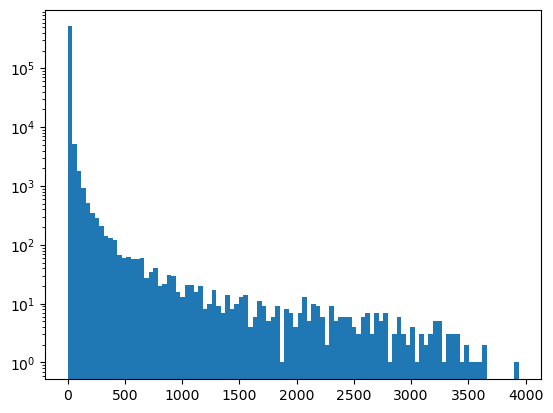

In [43]:
from astropy.stats import sigma_clipped_stats
spit_hst = plt.hist(spitzer_image.flatten(), bins=100, log=True)
mean_bkg, median_bkg, std_bkg = sigma_clipped_stats(spitzer_image, sigma=3.0)
print((mean_bkg , median_bkg , std_bkg)) 

Given the potential presence of outliers, it is better to take the median.

One can notice that lowering the sigma threshold also lowers the mean/median background level:

In [44]:
from astropy.stats import sigma_clipped_stats
mean_bkg , median_bkg, std_bkg  = sigma_clipped_stats(spitzer_image, sigma=2.5)
print((mean_bkg , median_bkg , std_bkg)) 

(np.float32(4.042252), np.float32(3.7515738), np.float32(1.2752802))


<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 2.2:** Read in the file `data/M13_blue_0001.fits` and:

1. Estimate uncertainties on the pixel intensities. Assume that the latter correspond to photon counts, and consider Poisson noise uncertainties.
2. Estimate and subtract the background from the image.
3. Measure the flux for the brightest point source in the M13 field in a 4 pixel-radius aperture, including error.

</div>

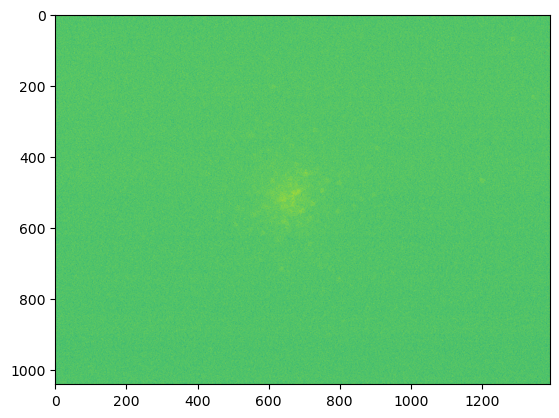

In [87]:
img_M13 = fits.getdata('data/M13_blue_0001.fits')
plt.imshow(img_M13)

In [88]:
mean_bkg, median_bkg, std_bkg = sigma_clipped_stats(img_M13, sigma=2.5)
median_bkg

np.float64(513.0)

In [89]:
img_M13_bgsub = img_M13 - median_bkg  # Calculate background subtracted image 

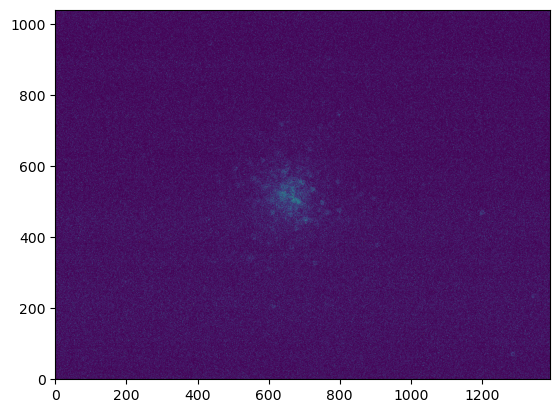

In [90]:
plt.imshow(img_M13_bgsub, vmin=0, origin='lower')   # display background subtracted image

In [91]:
# Calculate uncertainties on the pixels  assuming Poisson noise only 
unc_M13 = np.sqrt(img_M13)

In [92]:
# Find the coordinates of the brightest pixel in the background subtracted image
max_coords = np.argmax(img_M13_bgsub)
cy, cx = np.unravel_index(max_coords, img_M13_bgsub.shape)
print(cy, cx) 

528 648


(350.0, 750.0)

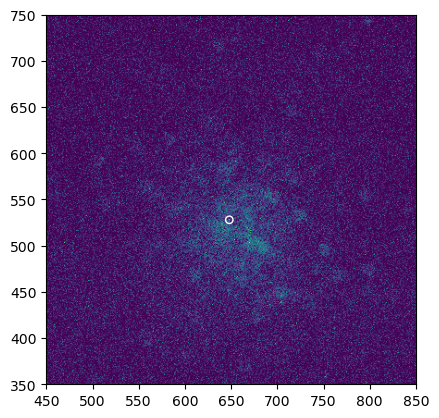

In [93]:
# Calculate and plot the aperture on the image
aperture = CircularAperture((cx, cy), r=4)
plt.imshow(img_M13_bgsub, vmin=0, origin='lower')
aperture.plot(color='white', lw=1) # Plot aperture on the image 
# let's zoom in to see the brightest pixel better
plt.xlim(450, 850)
plt.ylim(350, 750)

In [95]:
phot_table = aperture_photometry(img_M13_bgsub, aperture, error=unc_M13) # Calculate aperture photometry using "Error" as an argument  
phot_table

<QTable length=1>
  id  xcenter ycenter    aperture_sum    aperture_sum_err
int64 float64 float64      float64           float64     
----- ------- ------- ----------------- -----------------
    1   648.0   528.0 1977.652880173452 166.6248631281988

### 2.2. Annular estimate

One often wants to also estimate the **local background** around each source using a nearby aperture or annulus aperture surrounding each source. A simple method for doing this is to use the `ApertureStats` class to compute the mean background level within the background aperture. This class can also be used to calculate more advanced statistics (e.g., a sigma-clipped median) within the background aperture (e.g., a circular annulus).

**Examples:** Let's first generate a more realistic dataset.

In [96]:
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image()

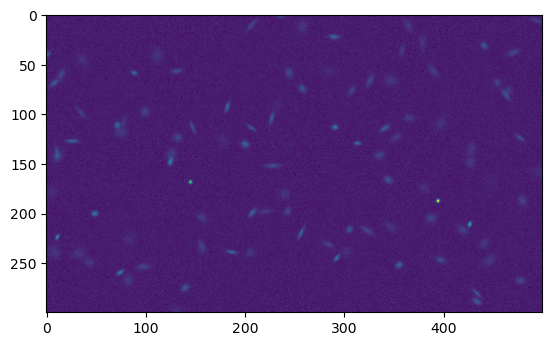

In [97]:
plt.imshow(data)

This artificial image has a known average background level of 5. Let's see if local background estimation manages to get rid of that contribution.

For this example we perform the photometry for three sources in a circular aperture with a radius of 5 pixels. The local background level around each source is estimated using a circular annulus of inner radius 10 pixels and outer radius 15 pixels. Let’s define the apertures:

In [48]:
from photutils.aperture import CircularAnnulus, CircularAperture

positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
aperture = CircularAperture(positions, r=5)
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

Now let’s plot the circular apertures (white) and circular annulus apertures (red) on a cutout from the image containing the three sources:

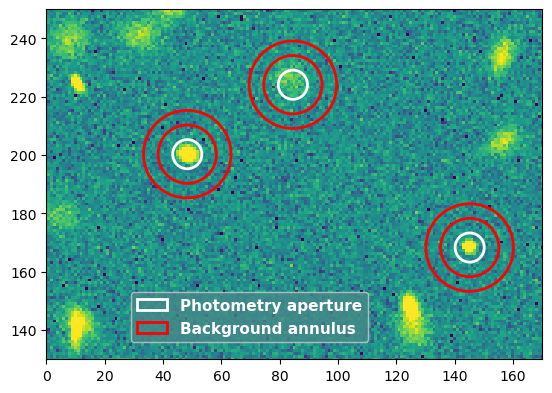

In [49]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from photutils.aperture import CircularAnnulus, CircularAperture
from photutils.datasets import make_100gaussians_image

norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest')
plt.xlim(0, 170)
plt.ylim(130, 250)

ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0]) # Get plot info of the first patch from each list of patches returned by the plot method -- to use in the legend
plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})


We can use the `ApertureStats` class to compute the mean background level within the annulus aperture at each position:

In [51]:
from photutils.aperture import ApertureStats
aperstats = ApertureStats(data, annulus_aperture)
bkg_mean = aperstats.mean
print(bkg_mean)  

[4.99411764 5.1349344  4.86894666]


In [52]:
aperstats.std

array([1.81090533, 1.9969047 , 1.90134673])

Close enough. Then it is only a matter of scaling these values by the size of the aperture used for aperture photometry, and subtracting the total expected contribution from the background.

In [53]:
phot_table = aperture_photometry(data, aperture)
print(aperture.area)
total_bkg = bkg_mean * aperture.area
phot_bkgsub = phot_table['aperture_sum'] - total_bkg

78.53981633974483


Let's finally add the background estimates and background subtracted photometry to the table:

In [54]:
phot_table['total_bkg'] = total_bkg
phot_table['aperture_sum_bkgsub'] = phot_bkgsub
print(phot_table)

 id xcenter ycenter    aperture_sum        total_bkg      aperture_sum_bkgsub
--- ------- ------- ------------------ ------------------ -------------------
  1   145.1   168.3 1128.1244679911656  392.2370818655997   735.8873861255659
  2    84.5   224.1  735.7389972944159 403.29680431444353  332.44219297997233
  3    48.3   200.3 1299.6340919576908  382.4061760715124   917.2279158861784


<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Supplementary exercise 2.3.:** Measure the flux for the 3 brightest point sources in the Spitzer image, after subtracting the estimated background level in a surrounding annulus. Consider appropriate values for the respective radii of the aperture and annulus. Beware of the presence of NaN values.

See [02_Photometry_Exr_Spitzer.ipynb](02_Photometry_Exr_Spitzer.ipynb) for a detailed solution. 

</div>

### 2.3. Gradient estimate

More advanced tools to estimate 2D background images are also available in photutils. Most are based on a masking of the brightest sources (in a similar fashion as `sigma_clipped_stats`) followed by a smoothing (low-pass spatial filter) of the images.

**Example:** Let's make 100 Gaussian sources and add a smooth background gradient:

In [55]:
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image()

In [56]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

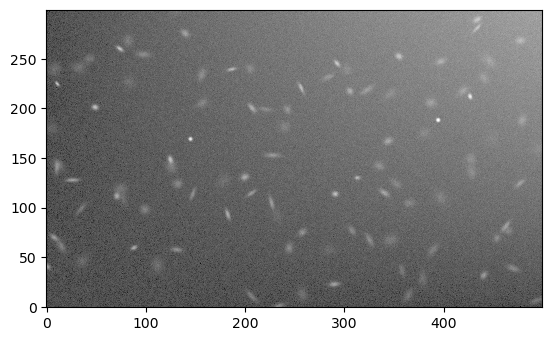

In [57]:
ny, nx = data.shape
y, x = np.mgrid[:ny, :nx]
gradient = x * y / 5000.0  # Add a gradient to the image for illustrating background estimation herebelow
data2 = data + gradient

norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data2, norm=norm, origin='lower', cmap='Greys_r',
           interpolation='nearest')  

We start by creating a `Background2D` object using a box size of 50x50 and a 3x3 median filter. We will estimate the background level in each mesh as the sigma-clipped median using an instance of `MedianBackground`.

In [59]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(data2, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

Let’s plot the estimated background image:

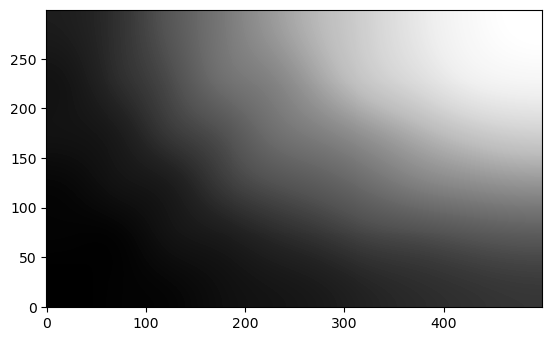

In [60]:
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',
           interpolation='nearest')

And the background-subtracted image:

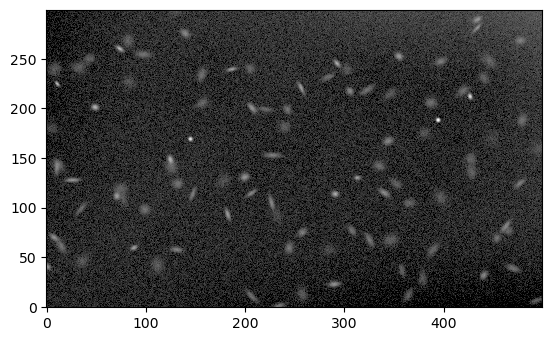

In [61]:
plt.imshow(data2 - bkg.background, norm=norm, origin='lower',
           cmap='Greys_r', interpolation='nearest')

Additional background estimation and subtraction methods available in `photutils` are described on [this page](https://photutils.readthedocs.io/en/stable/background.html).

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note:** When dedicated background images are taken close in time from the science observation, these should be used to estimate and subtract the background. A straightforward approach is to subtract the median of the stack of background images. More advanced approaches exist (some involving Principal Component Analysis - PCA). 
</div>

## 3. Source identification

### 3.1. Centroid measurement

`photutils.centroids` provides several functions to calculate the centroid of a single source:

- `centroid_com`: Calculates the object “center of mass” from 2D image moments.
- `centroid_quadratic`: Calculates the centroid by fitting a 2D quadratic polynomial to the data.
- `centroid_1dg`: Calculates the centroid by fitting 1D Gaussians to the marginal x and y distributions of the data.
- `centroid_2dg`: Calculates the centroid by fitting a 2D Gaussian to the 2D distribution of the data.

Masks can be input into each of these functions to mask bad pixels. Error arrays can be input into the two Gaussian fitting methods to weight the fits.

To calculate the centroids of many sources in an image, use the centroid_sources() function. This function can be used with any of the above centroiding functions or a custom user-defined centroiding function.

In [63]:
from photutils.datasets import make_4gaussians_image

data_all = make_4gaussians_image()
data = data_all[43:79, 76:104]

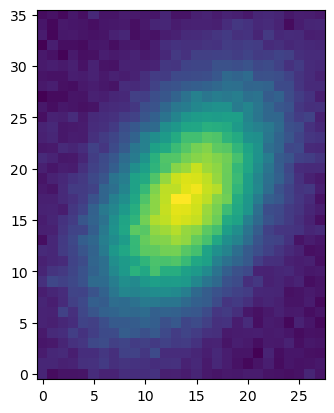

In [64]:
plt.imshow(data, origin='lower')

Let's compare the different methods:

In [65]:
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)

Coordinates found corresponding to the center of mass (COM) of the image:

In [67]:
x1, y1 = centroid_com(data)
print('x=%.2f, y=%.2f'%(x1, y1))

x=13.88, y=17.10


Coordinates found by fitting a 2D quadratic polynomial:

In [68]:
x2, y2 = centroid_quadratic(data)
print('x=%.2f, y=%.2f'%(x2, y2))

x=13.94, y=17.07


Coordinates found by fitting a 1D Gaussian:

In [69]:
x3, y3 = centroid_1dg(data)
print('x=%.2f, y=%.2f'%(x3, y3))

x=13.97, y=17.02


Coordinates found by fitting a 2D Gaussian:

In [70]:
x4, y4 = centroid_2dg(data)
print('x=%.2f, y=%.2f'%(x4, y4))

x=13.98, y=17.01


<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note:** An alternative for 2D model fitting, with a wider choice of models including also 2D Moffat or 2D Airy function, are the [2D model fitting utilities in Astropy](
https://docs.astropy.org/en/stable/modeling/fitting.html#simple-2-d-model-fitting).
</div>

Let's plot the results. Since they are all similar, let's include an inset:

(0.0, 35.0)

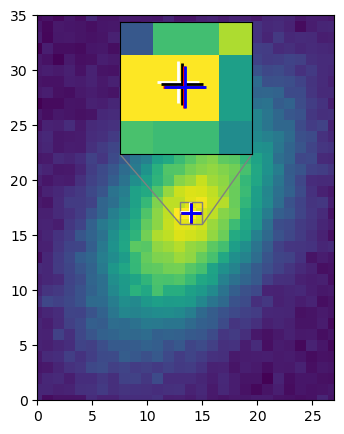

In [71]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,
                                                   zoomed_inset_axes)
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)
from photutils.datasets import make_4gaussians_image

data = make_4gaussians_image()[43:79, 76:104]  # extract single object
xycen1 = centroid_com(data)
xycen2 = centroid_quadratic(data)
xycen3 = centroid_1dg(data)
xycen4 = centroid_2dg(data)
xycens = [xycen1, xycen2, xycen3, xycen4]
fig, ax = plt.subplots(1, 1, figsize=(4, 5))
ax.imshow(data, origin='lower', interpolation='nearest')
marker = '+'
ms, mew = 15, 2.0
colors = ('white', 'black', 'red', 'blue')
for xycen, color in zip(xycens, colors):
    plt.plot(*xycen, color=color, marker=marker, ms=ms, mew=mew)

ax2 = zoomed_inset_axes(ax, zoom=6, loc=9)
ax2.imshow(data, vmin=190, vmax=220, origin='lower',
           interpolation='nearest')
ms, mew = 30, 2.0
for xycen, color in zip(xycens, colors):
    ax2.plot(*xycen, color=color, marker=marker, ms=ms, mew=mew)
ax2.set_xlim(13, 15)
ax2.set_ylim(16, 18)
mark_inset(ax, ax2, loc1=3, loc2=4, fc='none', ec='0.5')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax.set_xlim(0, data.shape[1] - 1)
ax.set_ylim(0, data.shape[0] - 1)

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Supplementa Exercise 3.1:** Calculate the center of mass (COM) of M13 on each of the 5 images and use it to align the images.    

While flexible and conceptually simple, this method is not always very accurate. We will see another method below a method using `skimage.registration` that is simpler to implement and may be your first choice.  

Load all 5 images of M13 (`'data/M13_blue_000n.fits'`), then:

1. Estimate and subtract the background based on the method you deem the most fitting.
2. Align the images based on the location of their center of mass (align e.g. with respect to first one).
3. Stack them and write a new FITS file, including a modified header.

Tip: use the `shift` function from `scipy.ndimage` for subpixel shifts. Basic usage: `shifted_image = shift(image, (shift_y, shift_x))`. As usual more info in dosctrings.

See [02_Photometry_alignement_M13.ipynb](02_Photometry_alignement_M13.ipynb) for an outline of the solution

</div>

### 3.2. Image alignment

A common task required before stacking astronomical images is to **align them** first. There is indeed always some jitter. An appropriate approach is to search for shifts that maximize the pair-wise cross-correlation between images of the stack.

`scikit-image` has a routine to do this, based on maximimizing cross-correlation in the Fourier plane: `phase_cross_correlation`.

#### Concept of the phase cross correlation: 

The key idea behind this method is the Fourier shift theorem. Suppose you have two images $I_2$ and $I_1$:

$$
I_2(x, y) = I_1(x - \Delta x,\, y - \Delta y)
$$

where the second image is just a shifted version (by $\Delta x, \Delta y)$ of the first.

A shift in image space becomes a **phase ramp** in Fourier space:

$$
\mathcal{F}[I_2] = F_2(u,v)
= F_1(u,v)\, e^{-i (u\,\Delta x + v\,\Delta y)}
$$

So the amplitudes are the same, but the phases differ by a known linear term. 

That’s why doing things in Fourier space instead of direct space is powerful: *Shifts become simple phase changes*. 

Now, what about the cross correlation? 
In real space, the cross-correlation between two images is:

$$
C(\Delta x, \Delta y) = 
\sum_{x,y} I_1(x,y)\, I_2(x+\Delta x, y+\Delta y)
$$

The maximum of this function occurs at the shift $$(\Delta x, \Delta y)$$ (you need to repeat the calculation for a range of shifts to find that one that maximizes the the cross correlation function $C()$). 

In Fourier space, we can make use of the following identity:

$$
\text{CC} = \mathcal{F}^{-1} \left(F_1 \cdot F_2^*\right)
$$

Where $F_1, F_2$ are Fourier transform of $F$

*   $F_1 = \mathcal{F}[I_1]$ 
*   $F_2 = \mathcal{F}[I_2]$
*   $F_2^*$ means complex conjugate

If the images differ only by a shift:

$$
F_2 = F_1 \, e^{-i(u\Delta x + v\Delta y)}
$$

Then:

$$
F_1 \cdot F_2^* =
|F_1|^2 \, e^{+i(u\Delta x + v\Delta y)}
$$

Now take the inverse Fourier transform:

$$
\mathcal{F}^{-1}[|F_1|^2 \, e^{i(u\Delta x + v\Delta y)}]
= \delta(x - \Delta x,\, y - \Delta y)
$$

This is a **delta function ("spike") located at the shift**!

So the shift becomes a single bright peak in the correlation image and finding the shift means: *Locate the pixel of maximum value*.

The method is efficient, fast, insensitive to **small** intensity variations. 

**Example 1:** Pixel-precision alignment.

Known offset (y, x): (-22.4, 13.32)
Detected pixel offset (y, x): [ 22. -13.] (using skimage.registration,phase_cross_correlation() method)


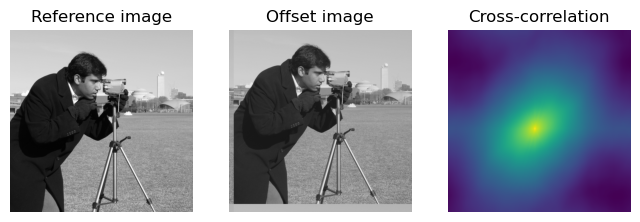

Detected pixel offset (y, x): [ 22. -13.]


In [79]:
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

image = data.camera()
shift = (-22.4, 13.32)
# Let's arbitrarily create a shifted imae - The shift corresponds to the pixel offset relative to the reference image 
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
print(f'Known offset (y, x): {shift}')

# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image) # with noisy images it is recommended to add: "normalization=None"
print(f'Detected pixel offset (y, x): {shift} (using skimage.registration,phase_cross_correlation() method)')

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scene
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()  # F1 * F2* (where F2* is the complex conjugate of F2) 
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))  # The cross-correlation is the inverse Fourier transform of the product of F1 and F2*. 
# The Fourier shift theorem states that a shift in the spatial domain corresponds to a phase shift in the Fourier domain. 
# Therefore, by multiplying F1 and F2*, we are effectively applying a phase shift to one of the images, which allows us to determine the amount of shift between the two images. 
# The resulting cross-correlation image will have a peak at the location corresponding to the detected shift.
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f'Detected pixel offset (y, x): {shift}')

For sub-pixel accuracy shifts, it is recommended to increase `upsample_factor` (e.g. `upsample_factor=100` means a requested precision of 1/100 pixel; increasing this parameter also makes it slower).

For noisy images, it is recommended to set `normalization=False`.

**Example 2:** Sub-pixel precision alignment.

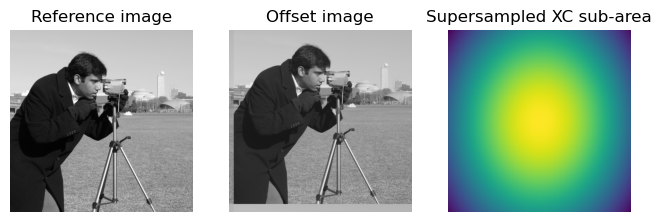

Known offset (y, x): [ 22.4  -13.32]
Detected subpixel offset (y, x): [ 22.4  -13.32]


In [98]:
# subpixel precision
shift, error, diffphase = phase_cross_correlation(image, offset_image,
                                                  upsample_factor=100) # with noisy images it is recommended to add: "normalization=None"

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()  # F1 * F2* (where F2* is the complex conjugate of F2) 
cc_image = _upsampled_dft(image_product, 150, 100, (shift * 100) + 75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print(f'Known offset (y, x): {shift}')
print(f'Detected subpixel offset (y, x): {shift}')

In [99]:
_upsampled_dft?

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 3.2:** Align the 5 images of M13 based on maximum cross-correlation, and with an upsample factor of 100:

1. Subtract a background of 486. from the original data (Getting a correct backround for that image is a bit tricky)
2. Align the images with respect to the first one based on their pair-wise cross-correlation.
3. Stack them and write a new FITS file, including a modified header.

</div>

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-info"> 
Note that in the present case the results are sensistive to the background subtraction. A general rule: **DO NOT BLINDLY TRUST the results of a tool**. Use your critical thinking to find out if the results are sensible and/or depend on parameters that seem arbitrary (or arguments of your function with default values). If results depends on parameters that seem arbitrary, this means that you will have to understand more finely how that method works ! 

</div>

In [100]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

# load images into a cube for simpler manipulation
nim = 5
cube_M13 = []
for i in range(nim):
    img_M13 = fits.getdata('data/M13_blue_{:04d}.fits'.format(i+1))
    cube_M13.append(img_M13)
cube_M13 = np.array(cube_M13) # convert into a numpy array

**1.** Subtract a constant background from the data 

In [101]:
M13_minus_bkg = cube_M13 - 486.0   # Subtract constant background from that image 

**2. Alignment based on cross-correlation**

Let's consider the first image of the background-subtracted cube as reference. We will align the other ones with respect to that one.
Also we will crop to only the inner part of the image to keep the core of the information.

In [102]:
# CROP
y_min, y_max = 300, 700
x_min, x_max = 450, 850
M13_crop = M13_minus_bkg[:, y_min:y_max, x_min:x_max]

In [104]:
ref_image = M13_crop[0]  # Take the first cropped image of the cube as reference image 

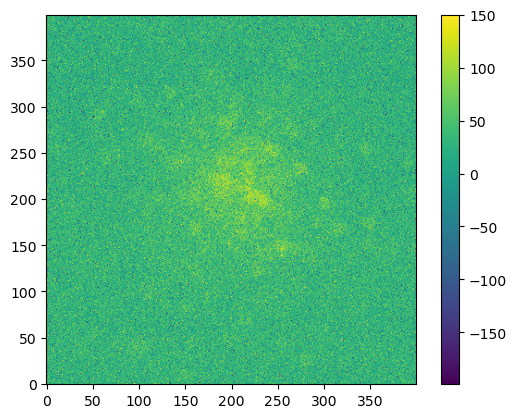

In [105]:
plt.imshow(ref_image, vmax=150, origin='lower')
plt.colorbar()

One can provide a mask (`reference_mask` argument) with the cross-correlation function. Let's use that feature, and only consider pixels with an intensity larger than a certain threshold.

For each n-1 pairs of images (with the first one) in the cube, the mask is taking all pixel locations that are above this threshold in either or the other image of the pair.  

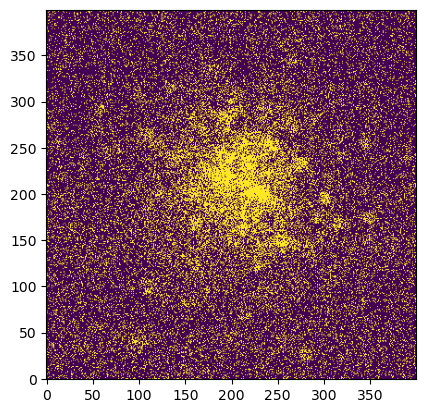

In [106]:
min_thr = 50 

mask1 =  np.zeros_like(ref_image)
mask1[np.where(ref_image>min_thr)] = 1    # Values larger than the threshold should have value = 1 in the mask 
plt.imshow(mask1, origin='lower')


In [107]:
# Calculate ths shifts between the reference image and the other images in the cube using phase cross-correlation method.
shifts = []
for i in range(nim-1):
    mask2 = np.zeros_like(M13_crop[i+1])
    mask2[np.where(M13_crop[i+1]>min_thr)] = 1
    ref_mask = mask1+mask2
    ref_mask[np.where(ref_mask==2)]=1
    
    shift_tmp, error, diffphase = phase_cross_correlation(ref_image, M13_crop[i+1],
                                                      upsample_factor=1,
                                                      reference_mask=ref_mask,
                                                      normalization=None) # with noisy images it is recommended to add: "normalization=None"
    shifts.append(shift_tmp)

In [108]:
shifts

[array([ 0., 11.]), array([-2., 26.]), array([-5., 33.]), array([-5., 48.])]

Let's now align the images based on these shifts, and save the cube:

In [109]:
from scipy.ndimage import shift

aligned_cube = [M13_minus_bkg[0]]
for i in range(nim-1):
    aligned_cube.append(shift(M13_minus_bkg[i+1], (shifts[i][0], shifts[i][1])))
aligned_cube = np.array(aligned_cube)

In [111]:
fits.writeto('outputs/aligned_cube_cc.fits', aligned_cube, overwrite=True)

**2. Stack and save after modifying header**

In [112]:
stacked_image = np.sum(aligned_cube, axis=0)

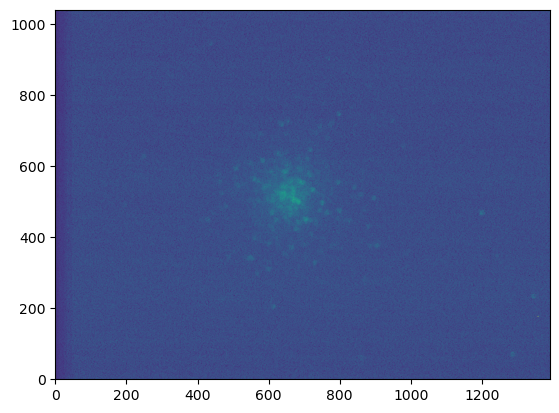

In [113]:
plt.imshow(stacked_image, vmin=np.percentile(stacked_image,0.1), origin='lower')

The stacked imaged looks much better now.

Let's load the original header for the first file

In [114]:
orihead = fits.getheader('data/M13_blue_0001.fits')

Let's now make a copy and edit the header copy:

In [115]:
from datetime import datetime
now = datetime.now()
new_head = orihead.copy()
new_head['COMMENT'] = 'Combination of 5 images after cross-correlation alignment'
new_head['HISTORY'] = 'Last edited on '+now.strftime('%Y-%m-%d %H:%M:%S')

In [116]:
new_head

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 1392 /fastest changing axis                           
NAXIS2  =                 1040 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
INSTRUME= 'Orion SSDSI' /       instrument or camera used                       
DATE-OBS= '2013-05-05T04:09:39' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   5.0000000000000000 /Exposure time in seconds                        
EXPOSURE=   5.0000000000000000 /Exposure time in seconds                        
XPIXSZ  =   6.4500000000000002 /Pixel Width in microns (after binning)          
YPIXSZ  =   6.45000000000000

Let's now make save the stacked image with new header:

In [117]:
outfile = 'outputs/M13_blue_stacked_cc.fits'

hdu = fits.PrimaryHDU(stacked_image, header=new_head)

In [118]:
hdu.writeto(outfile, overwrite=True)

### 3.3. Automatic source finding

`Photutils` includes two widely-used tools that are used to detect stars in an image, DAOFIND and IRAF’s starfind, plus a third tool that allows input of a custom user-defined kernel. More details on them are available [here](https://photutils.readthedocs.io/en/stable/reference/detection_api.html).

**Example:**

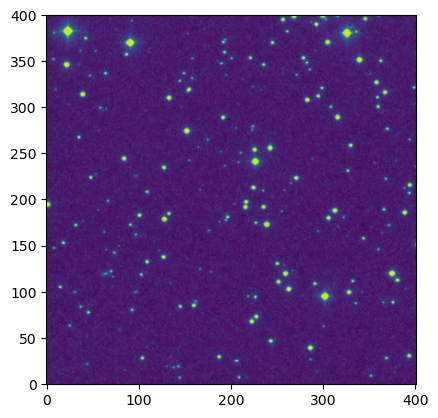

In [72]:
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
hdu = load_star_image()  
data = hdu.data[0:401, 0:401] 

plt.imshow(data, origin='lower')

In [76]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std))

(np.float64(3668.09661145823), np.float64(3649.0), np.float64(204.41388592022315))


Now we will subtract the background and use an instance of DAOStarFinder to find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. Running this class on the data yields an astropy Table containing the results of the star finder:

In [77]:
from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(data - median)  
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76)  

 id xcentroid ycentroid sharpness ...   peak     flux    mag   daofind_mag
--- --------- --------- --------- ... ------- --------- ------ -----------
  1    144.25      6.38      0.58 ... 6903.00  45735.00 -11.65       -1.89
  2    208.67      6.82      0.48 ... 7896.00  62118.00 -11.98       -2.07
  3    216.93      6.58      0.69 ... 2195.00  12436.00 -10.24       -0.55
  4    351.63      8.55      0.49 ... 6977.00  55313.00 -11.86       -1.93
  5    377.52     12.07      0.52 ... 1260.00   9078.00  -9.89       -0.12
  6    294.27     12.74      0.68 ... 2059.00  15818.00 -10.50       -0.43
  7     85.22     14.71      0.62 ... 1458.00   7413.00  -9.67       -0.24
  8    137.94     17.46      0.54 ... 5451.00  38267.00 -11.46       -1.68
  9    130.33     18.68      0.63 ... 3432.00  19551.00 -10.73       -1.14
 10    143.11     18.62      0.52 ... 6722.00  48799.00 -11.72       -1.90
...       ...       ...       ... ...     ...       ...    ...         ...
277     92.38    393.25  

Let’s plot the image and mark the location of detected sources:

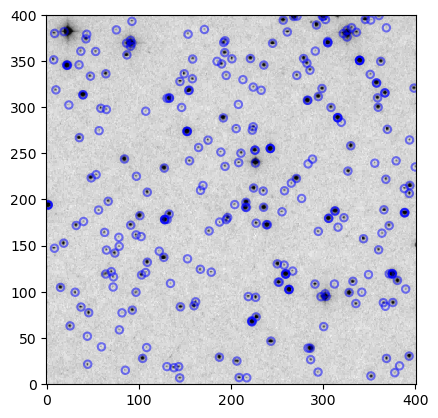

In [78]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5); 

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 3.3:** Take the image of the Horsehead nebula (`'data/HorseHead.fits'`):

1. Automatically find stars in the HorseHead nebula image,
2. Overplot circles at their location,
3. Estimate the noise in the image assuming that we have Poisson noise 
4. Measure the aperture photometry of the stars including Poisson noise uncertainties, and after subtracting annular estimates of the background.

</div>

**1.** Automatically find stars in the HorseHead nebula image,

In [119]:
img_hh = fits.getdata('data/HorseHead.fits')

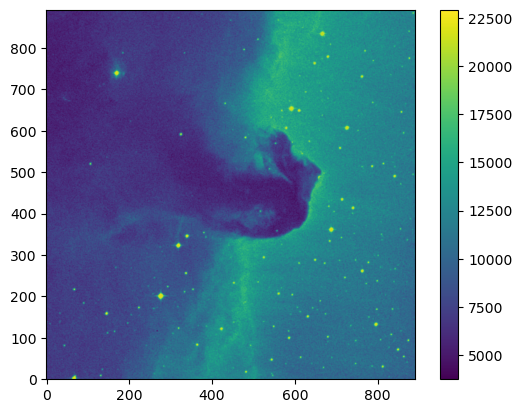

In [120]:
plt.imshow(img_hh, origin='lower')
plt.colorbar()

In [121]:
# let's extract basic statistics about the image
mean, median, std = sigma_clipped_stats(img_hh, sigma=2.5)  
print((mean, median, std))

(np.float64(9798.09107958365), np.float64(9622.0), np.float64(2983.028529592718))


In [122]:
# let's estimate the background in the upper left of the image where there is no emission from the nebula. 
bkg_est = np.median(img_hh[600:,:300])
bkg_est

np.float64(6314.0)

In [123]:
from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=6.0, threshold=3.*std)  
sources = daofind(img_hh - bkg_est)  
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76)  

 id xcentroid ycentroid sharpness ...   peak      flux    mag   daofind_mag
--- --------- --------- --------- ... -------- --------- ------ -----------
  1     65.82      1.91      0.42 ... 15361.00 415139.00 -14.05       -0.89
  2     68.76      2.25      0.43 ... 16375.00 471388.00 -14.18       -0.82
  3     69.09      3.40      0.37 ... 14234.00 511060.00 -14.27       -0.36
  4    131.83      8.15      0.49 ... 14361.00 278919.00 -13.61       -0.98
  5    546.96      8.51      0.59 ... 12412.00 357507.00 -13.88       -0.21
  6    482.52     17.02      0.32 ... 14744.00 524150.00 -14.30       -0.56
  7    135.61     22.96      0.64 ...  9330.00 151751.00 -12.95       -0.35
  8    669.60     27.43      0.53 ... 12371.00 332110.00 -13.80       -0.44
  9    812.62     29.74      0.30 ... 14814.00 514592.00 -14.28       -0.69
 10    284.03     30.70      0.61 ... 11075.00 321509.00 -13.77       -0.05
...       ...       ...       ... ...      ...       ...    ...         ...
120    185.1

**2.** Overplot circles at the location of the detected stars

In [124]:
nsources = len(sources)
nsources

129

In [125]:
positions = [(sources['xcentroid'][i], sources['ycentroid'][i]) for i in range(nsources)]
apertures = CircularAperture(positions, r=10)

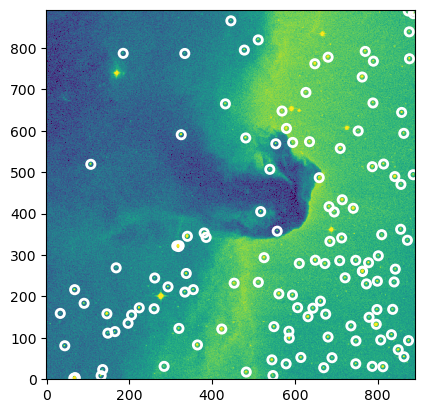

In [126]:
# plot
norm = simple_norm(img_hh, 'sqrt', percent=99.9)
plt.imshow(img_hh, norm=norm, interpolation='nearest', origin='lower')
ap_patches = apertures.plot(color='white', lw=2,
                               label='Photometry aperture')
plt.show()

From the above, we see that a FWHM of 6 pixels captures a lot of sources, but not the brightest ones. Let's try to capture more with a larger FWHM and a larger threshold.
This trial-and error approach is guided by by looking at 1D profile of some detected stars. You may see that the bright stars are a bit fatter than the fainter ones. This fatter when brighter effect is typical of some detectors. It impacts the fwhm but also the threshold of detection, because the peak of emission is less contrasted w.r.t. the extended emission. 

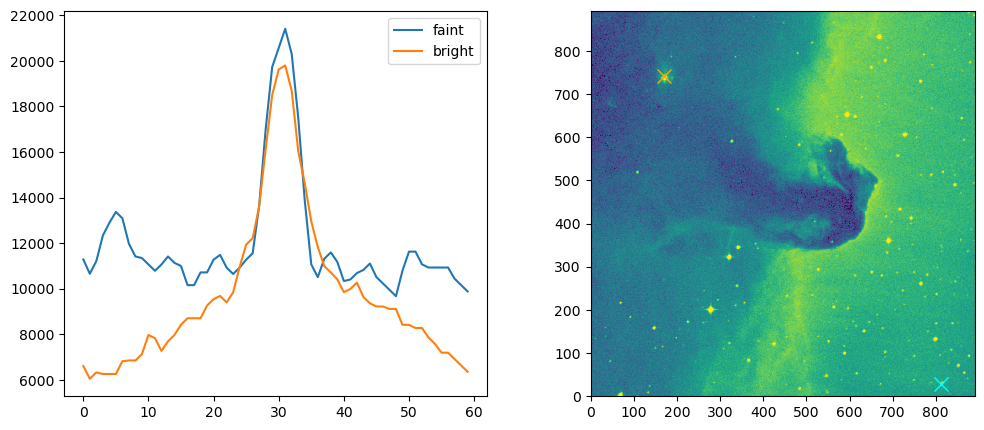

In [127]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(img_hh[29, 782:842], label='faint')  # A faint star
ax[0].plot(img_hh[743, 140:200], label='bright') # a bright star
ax[0].legend()
ax[1].imshow(img_hh, norm=norm, interpolation='nearest', origin='lower')
ax[1].plot(812, 29, marker='x', color='cyan', markersize=10)
ax[1].plot(170, 743, marker='x', color='orange', markersize=10)

In [128]:
# Let's change the fwhm and threshold parameters to try to identify the bright sources 
from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=15.0, threshold=5.*std)  
bright_sources = daofind(img_hh - bkg_est)  
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        bright_sources[col].info.format = '%.2f'  # for consistent table output
bright_sources.pprint()  

 id xcentroid ycentroid sharpness ...   peak      flux     mag   daofind_mag
--- --------- --------- --------- ... -------- ---------- ------ -----------
  1     67.96      3.46      0.49 ... 16331.00 1448048.00 -15.40       -1.80
  2    546.14      9.92      0.64 ...  8447.00 1754346.00 -15.61       -0.15
  3    812.67     29.83      0.91 ... 14814.00 1888592.00 -15.69       -0.90
  4    544.06     46.37      0.85 ... 15102.00 2099235.00 -15.81       -0.94
  5    849.63     70.79      0.92 ... 16604.00 1858073.00 -15.67       -1.08
  6    364.37     82.15      0.85 ... 15511.00 2302909.00 -15.91       -0.92
  7    586.37     99.10      0.84 ... 15454.00 1953531.00 -15.73       -1.03
  8    423.21    120.56      0.63 ... 14886.00 3077115.00 -16.22       -0.83
  9    796.32    131.46      0.47 ... 15519.00 2469227.00 -15.98       -1.46
 10    631.68    150.61      0.87 ... 15806.00 1991708.00 -15.75       -1.03
...       ...       ...       ... ...      ...        ...    ...         ...

In [129]:
bpositions = [(bright_sources['xcentroid'][i], bright_sources['ycentroid'][i]) for i in range(len(bright_sources))]
bapertures = CircularAperture(bpositions, r=10)

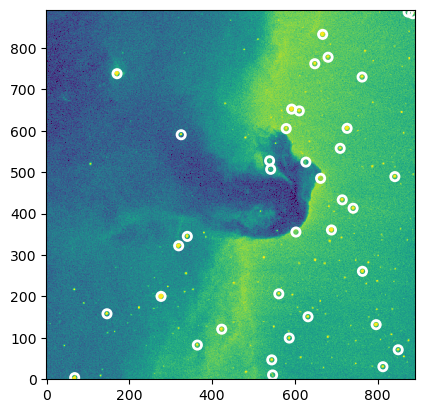

In [130]:
# plot
norm = simple_norm(img_hh, 'sqrt', percent=99.9)
plt.imshow(img_hh, norm=norm, interpolation='nearest', origin='lower')
ap_patches = bapertures.plot(color='white', lw=2, label='Photometry aperture')
plt.show()

We see that the new criteria now captures the brightest sources. Let's see how to merge the tables.

In [131]:
type(sources)
#sources?

astropy.table.table.QTable

We are dealing with QTables, this means we can concatenate them as we saw in Notebook 01, simply with:

In [132]:
from astropy.table import vstack

all_sources = vstack([sources, bright_sources])

In [133]:
all_sources.pprint()

 id xcentroid ycentroid sharpness ...   peak      flux     mag   daofind_mag
--- --------- --------- --------- ... -------- ---------- ------ -----------
  1     65.82      1.91      0.42 ... 15361.00  415139.00 -14.05       -0.89
  2     68.76      2.25      0.43 ... 16375.00  471388.00 -14.18       -0.82
  3     69.09      3.40      0.37 ... 14234.00  511060.00 -14.27       -0.36
  4    131.83      8.15      0.49 ... 14361.00  278919.00 -13.61       -0.98
  5    546.96      8.51      0.59 ... 12412.00  357507.00 -13.88       -0.21
  6    482.52     17.02      0.32 ... 14744.00  524150.00 -14.30       -0.56
  7    135.61     22.96      0.64 ...  9330.00  151751.00 -12.95       -0.35
  8    669.60     27.43      0.53 ... 12371.00  332110.00 -13.80       -0.44
  9    812.62     29.74      0.30 ... 14814.00  514592.00 -14.28       -0.69
 10    284.03     30.70      0.61 ... 11075.00  321509.00 -13.77       -0.05
...       ...       ...       ... ...      ...        ...    ...         ...

How would you proceed to avoid any duplicates in this merged table? Hint: the answer is also in Notebook 06.

**3** Estimate the noise in the image assuming that we have Poisson noise  

In [134]:
Poisson_unc = np.sqrt(img_hh)  # Poisson uncertainty is the square root of the counts in each pixel. ; Done on the image NOT background subtracted !    

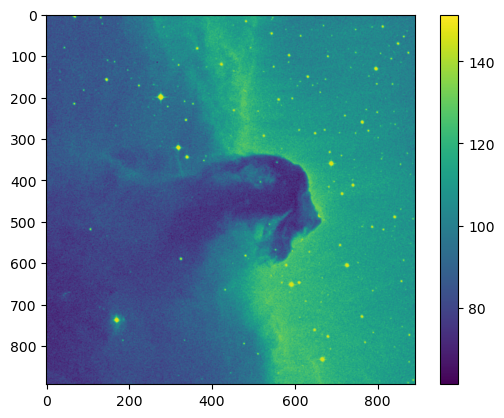

In [135]:
plt.imshow(Poisson_unc)
plt.colorbar()

**4. Photometry including Poisson noise uncertainties after *local* background subtraction**

Let's first consider circular and annular apertures:

In [136]:
all_positions = [(all_sources['xcentroid'][i], all_sources['ycentroid'][i]) for i in range(len(all_sources))]

In [137]:
apertures = CircularAperture(all_positions, r=10)
annuli = CircularAnnulus(all_positions, r_in=20, r_out=25)

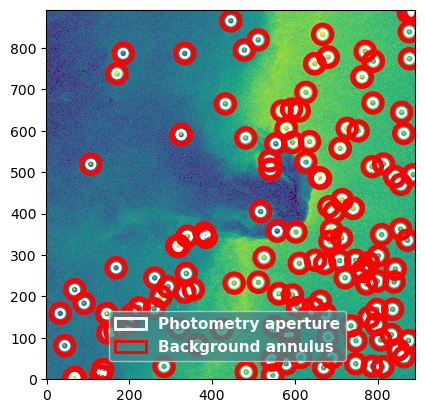

In [138]:
# plot
ax = plt.subplot()
ax.imshow(img_hh, origin='lower')
norm = simple_norm(img_hh, 'sqrt', percent=99.9)
ax.imshow(img_hh, origin='lower', norm=norm, interpolation='nearest')

ap_patches = apertures.plot(color='white', lw=2,
                            label='Photometry aperture')
ann_patches = annuli.plot(color='red', lw=2, label='Background annulus')
handles = (ap_patches[i], ann_patches[i])
plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

Then let's calculate the photometry in each.

In [139]:
n_all = len(all_sources)

In [140]:
# backgrounds
from photutils.aperture import ApertureStats
aperstats = ApertureStats(img_hh, annuli)
bkg_median = aperstats.median
bkg_median  

array([ 7311.5,  7316. ,  7318. ,  7491. , 11112. , 12848. ,  7456. ,
       10457. , 10441. , 11301. , 10629. , 10570. , 10704. , 11154. ,
       10439. , 10645. , 10206. , 10350. ,  7263. , 11361. , 10861. ,
       10144. , 10717. , 10719. , 10750. , 10577. ,  7538.5,  7709. ,
       10754. , 10322. , 13217. , 11381. , 10856.5, 10926. ,  7908. ,
       11038. , 10992. ,  8067. ,  7604. , 10835. ,  7111. , 10933. ,
       10568. ,  8757. , 11107.5,  8320. , 11258. ,  7381. , 11240.5,
       11717. , 12274. ,  9164. ,  7325. ,  9620.5,  8867. , 11309. ,
       13760.5, 13671. , 10917. , 11161. ,  8569. , 11575. ,  8544. ,
       11562. , 11572. , 10984.5,  7653. , 12410. , 12087. , 11642. ,
       11960. , 12340. , 11704.5, 13759. , 11508.5,  8332. ,  8315. ,
        8332. , 12463. , 10947. , 12266. ,  8952. ,  8773. , 11663. ,
        8485. ,  6457. , 11322. , 13222. ,  7472. , 12746. , 13721.5,
       13000. , 11901. , 13845. , 12023.5, 11683. ,  8652. , 12380. ,
        6532. , 1220

As seen in the first section, this time we provide the Poisson uncertainty map as `error`, when calculating the aperture photometry.

In [141]:
phot_tables = aperture_photometry(img_hh, apertures, error=Poisson_unc)
total_bkg = bkg_median*apertures.area                     # scale bkg level by the area of each respective aperture 
phot_bkgsub = phot_tables['aperture_sum'] - total_bkg  # subtract bkg level

Let's finally add the background estimates and background subtracted photometry to each table:

In [142]:
phot_tables['total_bkg'] = total_bkg
phot_tables['aperture_sum_bkgsub'] = phot_bkgsub
print(phot_tables)

 id      xcenter       ...     total_bkg      aperture_sum_bkgsub
--- ------------------ ... ------------------ -------------------
  1  65.82406160206982 ... 2296975.4686721773  403208.59689226886
  2  68.76165401881379 ...  2298389.185366293   448918.4975569281
  3  69.09193841874401 ...  2299017.503897011   611983.9527677367
  4 131.82816796749407 ...  2353367.056804114  152123.79836259596
  5   546.963642842742 ... 3490937.7566689784  138580.89773620572
  6  482.5197638760675 ... 4036318.2413321664  165692.65571401967
  7 135.60632763073812 ...   2342371.48251655   53899.29221729608
  8  669.5988834265254 ...  3285163.437858847  137522.53348648548
  9  812.6244620375471 ...  3280136.889613103   399166.9901984995
 10 284.03441140182844 ... 3550313.8578218254   78315.59717424819
...                ... ...                ...                 ...
158   726.158225918013 ... 4109831.5094261677   780959.9142640554
159  610.6101001621494 ...  4673119.072214818  217268.59374282695
160  592.1

Note: for more accurate estimates, one could have considered smaller/larger apertures for fainter/brighter sources. This would have implied repeating the above with different aperture sizes.

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note:** In this lecture, we only considered the case of measuring the photometry of unresolved point sources. For **extended elliptical sources** (e.g. galaxies) it is common to use **isophotes** instead. The interested reader can refer to the [following instructions](https://photutils.readthedocs.io/en/stable/isophote.html) explaining how to use the tools available in `photutils` in such case. A more general, yet very convenient, `photutils` tool can also provide the [morphological properties](https://photutils.readthedocs.io/en/stable/morphology.html) of the intensity distribution.
</div>

[Go back to top](#Table-of-contents)

## References

- This notebook is mostly based on the astropy tutorials available [here](https://learn.astropy.org/).
- Your reference for using `astropy` should be the [online documentation](http://docs.astropy.org/en/latest). Here are links to specific documentation on [quantities](https://docs.astropy.org/en/stable/units/index.html), [constants](https://docs.astropy.org/en/stable/constants/index.html), the [`wcs` module](http://docs.astropy.org/en/stable/visualization/wcsaxes/), [FITS handling](https://docs.astropy.org/en/stable/io/fits/index.html), [`coordinates`](http://docs.astropy.org/en/stable/coordinates/index.html), [`Table` objects](http://docs.astropy.org/en/stable/table/io.html), and [modeling](https://docs.astropy.org/en/stable/modeling/index.html).
- Photutils documentation on [aperture photometry](https://photutils.readthedocs.io/en/stable/aperture.html) and [isophotes](https://photutils.readthedocs.io/en/stable/isophote.html).
- Scikit-image documentation on [phase cross-correlation](https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_translation.html). 

## Credits:

If you use Astropy directly—or as a dependency to another package—for your work, please remember to include the following acknowledgment at the end of papers:

*This research made use of Astropy, a community-developed core Python package for Astronomy (Astropy Collaboration, 2013).*

Where the astropy paper is 2013, A&A, 558, 33 http://adsabs.harvard.edu//abs/2013A%26A...558A..33A

[Go back to top](#Table-of-contents)